## NetPyNE Tutorial 3: Adding Stimulation to the Network

## Preliminaries

If you are going to run this notebook locally using Jupyter Notebook, start from following instructions https://github.com/suny-downstate-medical-center/netpyne/blob/development/netpyne/tutorials/README.md.

If you are using Open Source Brain or EBRAINS, everything is already set up.

On any other online platform (e.g. on Google Collab) you might need to run the following commmands to install NEURON and NetPyNE using **pip**:
```
!pip install neuron
!pip install netpyne
```

Now we are ready to start the tutorial.

Two dictionary structures are used to specify cell stimulation parameters: `stimSourceParams` to define the parameters of the sources of stimulation; and `stimTargetParams` to specify what cells will be applied what source of stimulation (mapping of sources to cells). See [Stimulation parameters](http://netpyne.org/user_documentation.html#stimulation) for details.

In this example, we will take as a starting point the simple network similar to that from the first tutorial, but with no connection parameters, and add external stimulation instead.

In [1]:
from netpyne import specs, sim

# Network parameters
netParams = (
    specs.NetParams()
)  # object of class NetParams to store the network parameters

## Cell params
secs = {}  # sections dict
secs["soma"] = {"geom": {}, "mechs": {}}  # soma params dict
secs["soma"]["geom"] = {"diam": 18.8, "L": 18.8}  # soma geometry
secs["soma"]["mechs"]["hh"] = {
    "gnabar": 0.12,
    "gkbar": 0.036,
    "gl": 0.003,
    "el": -70,
}  # soma hh mechanism
netParams.cellParams["PYR"] = {"secs": secs}  # add dict to list of cell params

## Population parameters
netParams.popParams["S"] = {"cellType": "PYR", "numCells": 20}
netParams.popParams["M"] = {"cellType": "PYR", "numCells": 20}

## Synaptic mechanism parameters
netParams.synMechParams["exc"] = {
    "mod": "Exp2Syn",
    "tau1": 0.1,
    "tau2": 5.0,
    "e": 0,
}  # excitatory synaptic mechanism

--No graphics will be displayed.


Below we add four typical NEURON sources of stimulation, each of a different type: `IClamp`, `VClamp`, `AlphaSynapse`, `NetStim`. Note that parameter values can also include string-based functions ([Functions as strings](http://netpyne.org/user_documentation.html#function-string)), for example to set a uniform distribution of onset values (`'onset': 'uniform(300,600)'`), or maximum conductance dependent on the target cell normalized depth (`'gmax': '4*post_ynorm'`):

In [2]:
## Stimulation parameters
netParams.stimSourceParams["Input_1"] = {
    "type": "IClamp",
    "del": 300,
    "dur": 100,
    "amp": "uniform(0.4,0.5)",
}

netParams.stimSourceParams["Input_2"] = {
    "type": "VClamp",
    "dur": [0, 50, 200],
    "amp": [-60, -30, 40],
    "gain": 1e5,
    "rstim": 1,
    "tau1": 0.1,
    "tau2": 0,
}

netParams.stimSourceParams["Input_3"] = {
    "type": "AlphaSynapse",
    "onset": "uniform(300,600)",
    "tau": 5,
    "gmax": "4*post_ynorm",
    "e": 0,
}

netParams.stimSourceParams["Input_4"] = {
    "type": "NetStim",
    "interval": "uniform(20,100)",
    "start": 600,
    "noise": 0.1,
}

Now we can map or apply any of the above stimulation sources to any subset of cells in the network by adding items to the `stimTargetParams` dict. Note that we can use any of the cell tags (e.g. `‘pop’`, `‘cellType’` or `‘ynorm’`) to select which cells will be stimulated. Additionally, using the `‘cellList’` option, we can target a specific list of cells (using relative cell ids) within the subset of cells selected (e.g. first 15 cells of the ‘S’ population):

In [3]:
netParams.stimTargetParams["Input_1->S"] = {
    "source": "Input_1",
    "sec": "soma",
    "loc": 0.8,
    "conds": {"pop": "S", "cellList": list(range(15))},
}

netParams.stimTargetParams["Input_2->S"] = {
    "source": "Input_2",
    "sec": "soma",
    "loc": 0.5,
    "conds": {"pop": "S", "ynorm": [0, 0.5]},
}

netParams.stimTargetParams["Input_3->M"] = {
    "source": "Input_3",
    "sec": "soma",
    "loc": 0.2,
    "conds": {"pop": "M"},
}

netParams.stimTargetParams["Input_4->PYR"] = {
    "source": "Input_4",
    "sec": "soma",
    "loc": 0.5,
    "synMech": "exc",
    "weight": "0.1+normal(0.2,0.05)",
    "delay": 1,
    "conds": {"cellType": "PYR", "ynorm": [0.6, 1.0]},
}

Set up configuration in a standard way, and run the simulation:


Start time:  2024-10-30 15:09:44.807644




Creating network of 2 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 40 
  Done; cell creation time = 0.02 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 61 
  Done; cell stims creation time = 0.01 s.
Recording 2 traces of 1 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 0.43 s; real-time ratio: 2.32.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 40
  Connections: 16 (0.40 per cell)
  Spikes: 148 (3.70 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 0.43 s
Preparing spike data...
Plotting raster...



exp(955.401) out of range, returning exp(700)
exp(955.901) out of range, returning exp(700)
exp(953.901) out of range, returning exp(700)
exp(1392.5) out of range, returning exp(700)
No more errno warnings during this execution


Plotting recorded cell traces ... cell


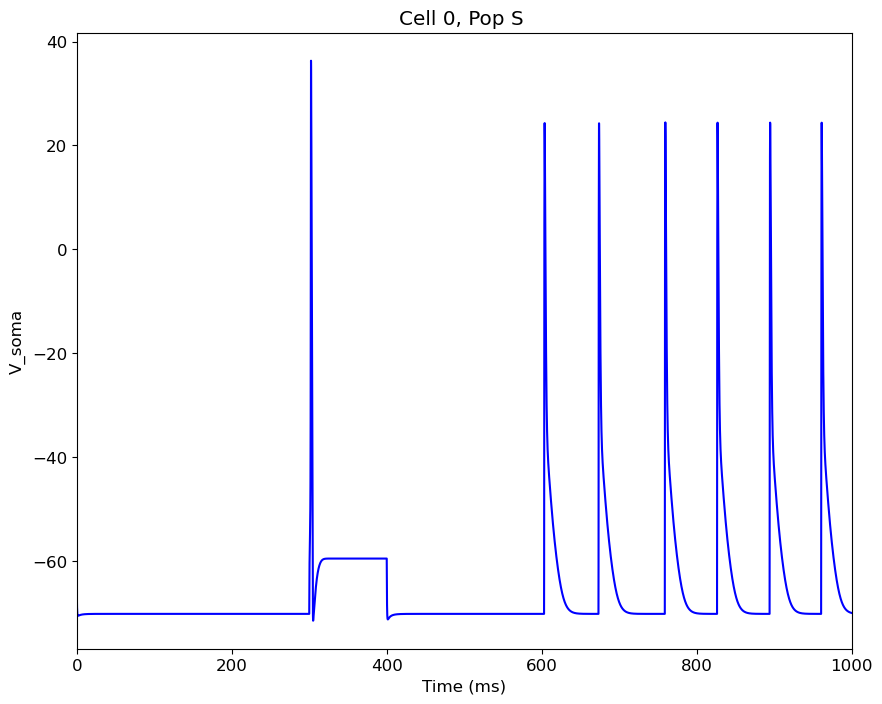

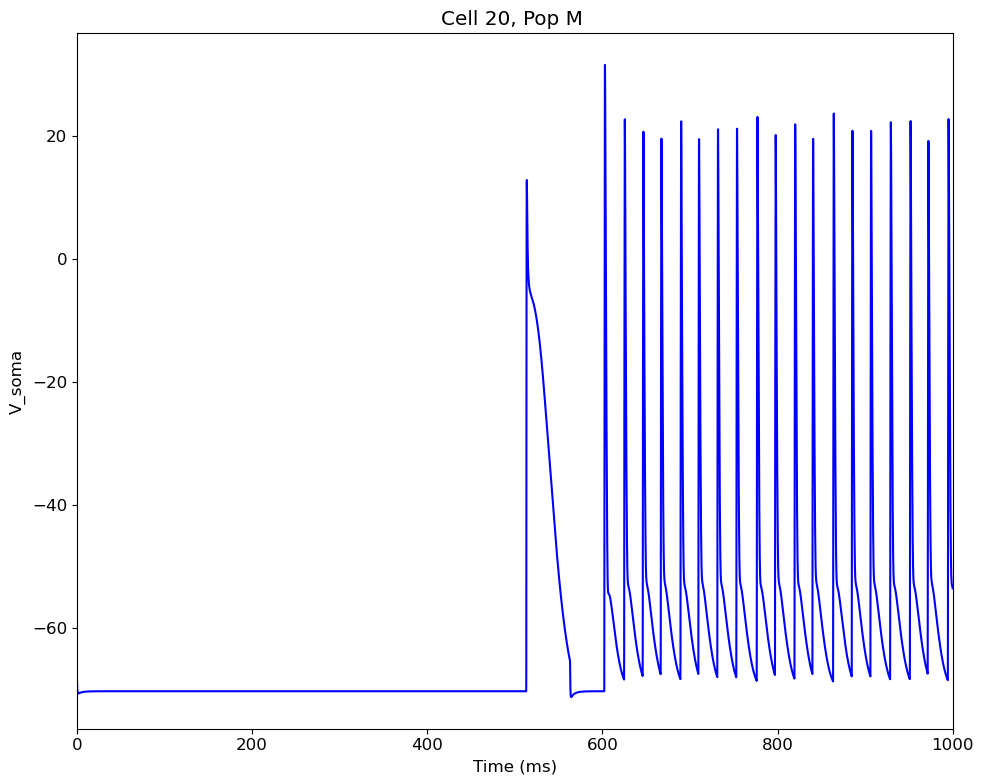

  Done; plotting time = 0.59 s

Total time = 1.05 s


In [4]:

# Simulation options
simConfig = specs.SimConfig()       # object of class SimConfig to store simulation configuration

simConfig.duration = 1*1e3          # Duration of the simulation, in ms
simConfig.dt = 0.025                # Internal integration timestep to use
simConfig.verbose = False           # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordStep = 0.1          # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig.filename = 'tut6'         # Set file output name
simConfig.savePickle = False        # Save params, network and sim output to pickle file

simConfig.analysis['plotRaster'] = {'saveFig': True, 'orderBy': 'y', 'orderInverse': True}                                 # Plot a raster
simConfig.analysis['plotTraces'] = {'include': [('S',0), ('M',0)], 'saveFig': True}  # Plot recorded traces for this list of cells

%matplotlib inline
# Create network and run simulation
sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)